In [95]:
import numpy as np
import pandas as pd
# import torch
# import scipy
import matplotlib.pyplot as plt
import seaborn

import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm

import torch.nn.functional as F
import torch


In [79]:
raw_data = np.loadtxt('Turbine.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*np.power(10,1)).astype(int).reshape(-1, 3)

In [80]:
int_cast_data.min(axis=0)

array([-258, -244,   -3])

In [81]:
shifted = (int_cast_data - int_cast_data.min(axis=0) + np.array([10,10,10]))

sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + np.array([20,20, 20])).astype(int)
tensor_3d = np.zeros(sizes, dtype=int)

tensor_3d[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

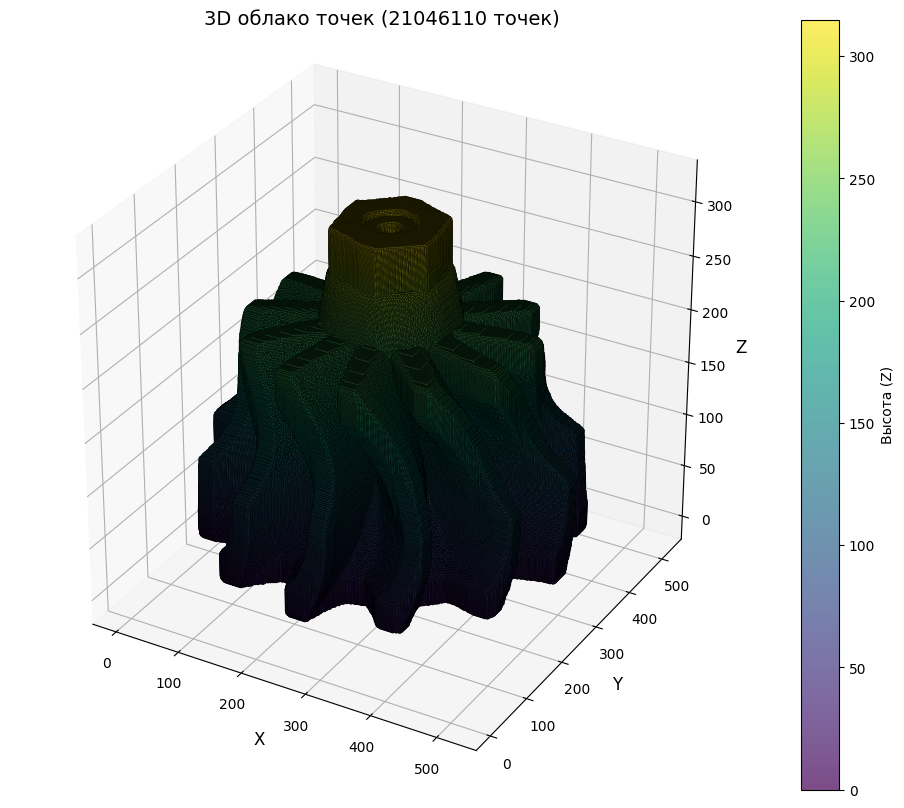

Всего точек: 21046110
Размер тензора: (522, 524, 316)
Плотность: 0.243491


In [91]:
points = np.argwhere(voxel_model != 0)
    

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, 
                    c=z,
                    cmap='viridis',
                    s=1,         
                    alpha=0.7,
                    edgecolors='k',
                    linewidth=0.5)

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title(f'3D облако точек ({len(points)} точек)', fontsize=14)

plt.colorbar(scatter, ax=ax, label='Высота (Z)')

ax.set_box_aspect([1, 1, 1])

plt.show()

print(f"Всего точек: {len(points)}")
print(f"Размер тензора: {tensor_3d.shape}")
print(f"Плотность: {len(points) / np.prod(tensor_3d.shape):.6f}")

In [83]:
def make_html_visual(tensor_3d, name):

    points = np.argwhere(tensor_3d != 0)
        
    title = "Облако точек"
        
    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    colors = z

    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=colors,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Z")
        ),
        text=[f'({xi}, {yi}, {zi})' for xi, yi, zi in points],
        hovertemplate='<b>Координаты</b>: %{text}<br>' +
                    '<b>Z</b>: %{z}<extra></extra>'
    )])

    fig.update_layout(
        title=dict(text=title, font=dict(size=20)),
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data' 
        ),
        width=1000,
        height=800,
        hovermode='closest'
    )

    fig.write_html(f"{name}.html")

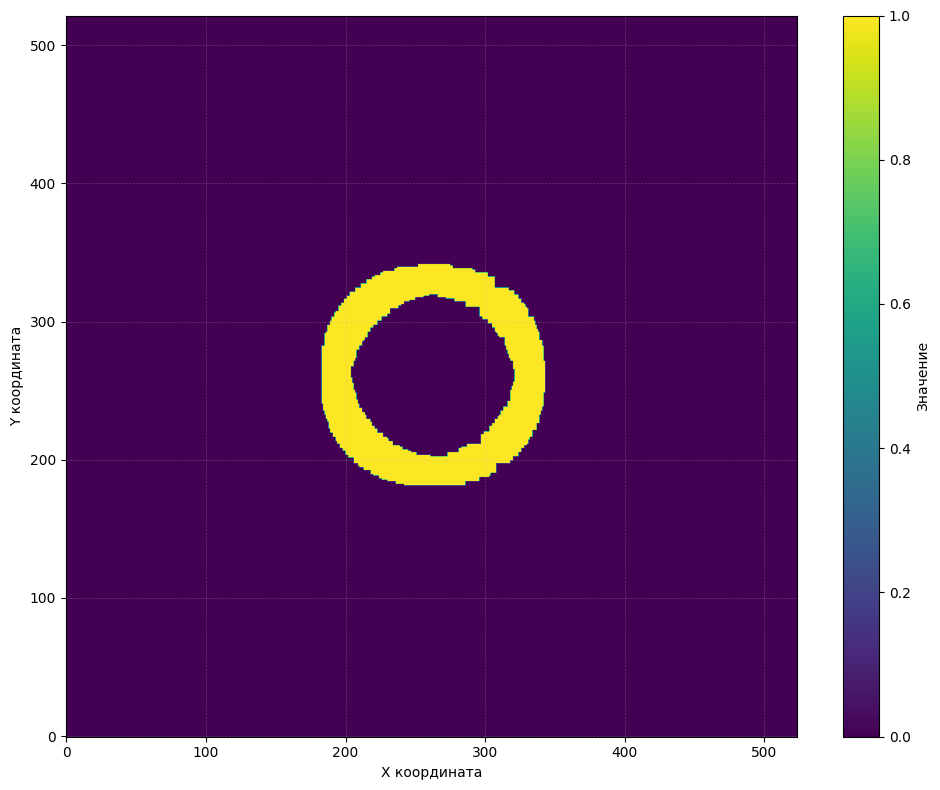

In [86]:
def make_conv_2d(source, kernel):

    result = np.zeros(shape = source.shape)

    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    source_pad = np.pad(source, 
                        pad_width=((pad_height, pad_height), (pad_width, pad_width)), 
                        mode='constant', 
                        constant_values=0)
    
    # print(source_pad)
                        
    source_pad_height, source_pad_widht = source_pad.shape

    kernel_height, kernel_widht = kernel.shape

    for i in range(source_pad_height - 2*pad_width):
        for j in range(source_pad_widht - 2*pad_width):
            value = min(
                        np.sum(source_pad[i:i + kernel_height, j: j + kernel_widht]*kernel),
                        1
                        )
            
            # value = np.sum(source_pad[i:i + kernel_height, j: j + kernel_widht]*kernel)
            # print(i,j, value)
            result[i][j] = value


    return result

tensor_slice = tensor_3d[:,:, 15]

conv_result = make_conv_2d(source=tensor_slice, kernel=np.ones(shape=(21,21)))


plt.figure(figsize=(10, 8))
    
plt.imshow(conv_result, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [87]:
def make_conv_3d(source, kernel):

    result = np.zeros(shape = source.shape)

    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    pad_length = kernel.shape[2] // 2
    
    source_pad = np.pad(source, 
                        pad_width=((pad_height, pad_height), (pad_width, pad_width), (pad_length, pad_length)), 
                        mode='constant', 
                        constant_values=0)
                        

    source_pad_height, source_pad_widht, source_pad_length = source_pad.shape

    kernel_height, kernel_widht, kernel_length = kernel.shape

    for i in tqdm(range(source_pad_height - 2*pad_height)):
        for j in (range(source_pad_widht - 2*pad_width)):
            for k in (range(source_pad_length - 2*pad_length)):

                value = min(
                            np.sum(source_pad[i:i + kernel_height, j: j + kernel_widht, k: k + kernel_length]*kernel),
                            1
                            )
                # print(i,j, k, value)
                result[i][j][k] = value


    return result

In [92]:
# def make_conv_3d_torch(source, kernel, device="cpu"):
#     source_t = torch.from_numpy(source).float().to(device)
#     kernel_t = torch.from_numpy(kernel).float().to(device)

#     # формат (N, C, D, H, W)
#     source_t = source_t.unsqueeze(0).unsqueeze(0)   # (1, 1, D, H, W)
#     kernel_t = kernel_t.unsqueeze(0).unsqueeze(0)   # (1, 1, kD, kH, kW)

#     padding = (
#         kernel.shape[2] // 2,
#         kernel.shape[1] // 2,
#         kernel.shape[0] // 2,
#     )

#     result = F.conv3d(source_t, kernel_t, padding=padding)

#     result = torch.clamp(result, max=1.0)

#     return result.squeeze().cpu().numpy()

In [88]:
voxel_model = make_conv_3d(tensor_3d, kernel=np.ones(shape=(21,21,21)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 522/522 [27:56<00:00,  3.21s/it]


In [112]:
# %time
# voxel_model_torch = make_conv_3d_torch(tensor_3d, kernel=np.ones(shape=(21,21,21)), device = "cuda")

In [89]:
make_html_visual(voxel_model, 'voxel_model')

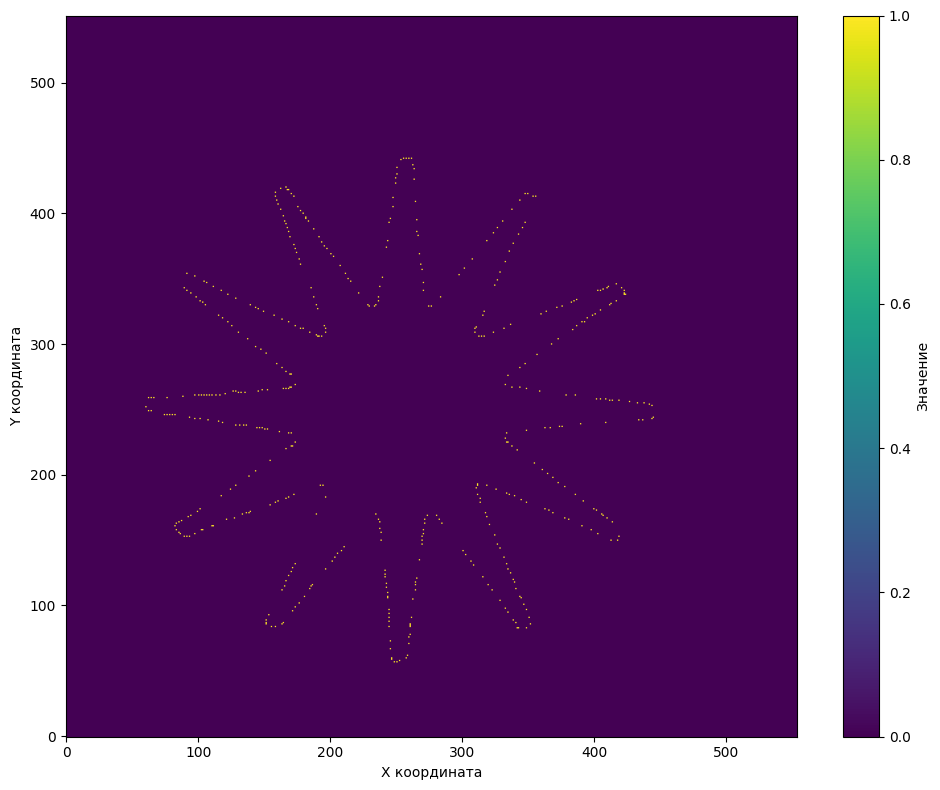

In [68]:
tensor_slice = tensor_3d[:,:, 150]

plt.figure(figsize=(10, 8))
    
plt.imshow(tensor_slice, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

# plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()